Importing Libraries.

In [1]:
BATCH_SIZE = 4
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback

/Users/kiro02/Library/Caches/pypoetry/virtualenvs/cub-2023oct-tIHWYxGD-py3.11/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Enabling TPU

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    tpu_strategy = tf.distribute.get_strategy()
print('Number of replicas:', tpu_strategy.num_replicas_in_sync)

AUTO_TUNE = tf.data.experimental.AUTOTUNE
    
print("version:",tf.__version__)

Number of replicas: 1
version: 2.15.0


Reading the data into variables

In [3]:
monets_tfr = tf.io.gfile.glob(str('./monet_tfrec/*.tfrec'))
photos_tfr = tf.io.gfile.glob(str('./photo_tfrec/*.tfrec'))


Count the records and files used in the dataset

In [4]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

monet_jpg = count_data_items(monets_tfr)
photo_jpg = count_data_items(photos_tfr)

EPOCHS = 30

print("Monet TFRecord files:", len(monets_tfr))
print("Monet image files:", monet_jpg)
print("Photo TFRecord files:", len(photos_tfr))
print("Photo image files:", photo_jpg)
print("EPOCHS:",EPOCHS)

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038
EPOCHS: 30


Setting up the Image Size

In [5]:
IMAGE_SIZE = [256, 256]

Decoding the Image

In [6]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

Read the TFRecord files

In [7]:
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting, Random jittering performs:

Resize an image to bigger height and width
Randomly crop to the target size
Randomly rotate the image

In [8]:
def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286]) #resizing to 286 x 286 x 3
        image = tf.image.random_crop(image, size=[256, 256, 3]) # randomly cropping to 256 x 256 x 3
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
        ## random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image


Load the dataset

In [9]:
def load_dataset(filenames):
    data = tf.data.TFRecordDataset(filenames)
    data = data.map(read_tfrecord, num_parallel_calls=AUTO_TUNE)
    return data

Define the GAN dataset

In [10]:
def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO_TUNE)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO_TUNE)
        
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO_TUNE)
    photo_ds = photo_ds.prefetch(AUTO_TUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

data = get_gan_dataset(monets_tfr, photos_tfr, augment=data_augment, repeat=True, shuffle=True, batch_size=BATCH_SIZE)

2023-12-10 11:00:17.423598: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-12-10 11:00:17.423620: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2023-12-10 11:00:17.423627: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2023-12-10 11:00:17.423663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 11:00:17.423685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Visualizing the data and checking that the upload is successful.

In [11]:
example_monet , example_photo = next(iter(data))

2023-12-10 11:00:19.712195: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-10 11:00:19.787433: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Visualizing the image.

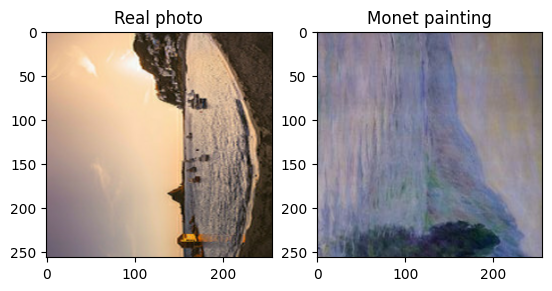

In [12]:
# Visualizing the real photo
plt.subplot(121)
plt.title('Real photo')
plt.imshow(example_photo[2] * 0.5 + 0.5)

# Visualizing the Monet painting
plt.subplot(122)
plt.title('Monet painting')
plt.imshow(example_monet[2]* 0.5 + 0.5)

Displaying Samples

In [13]:
def display_samples(dataset, nrows, ncols):
    ds_iter = iter(dataset)
    plt.figure(figsize=(15, int(15*nrows/ncols)))
    for j in range(nrows*ncols):
        monet_sample = next(ds_iter)
        plt.subplot(nrows,ncols,j+1)
        plt.axis('off')
        plt.imshow(monet_sample[0] * 0.5 + 0.5)
    plt.show()

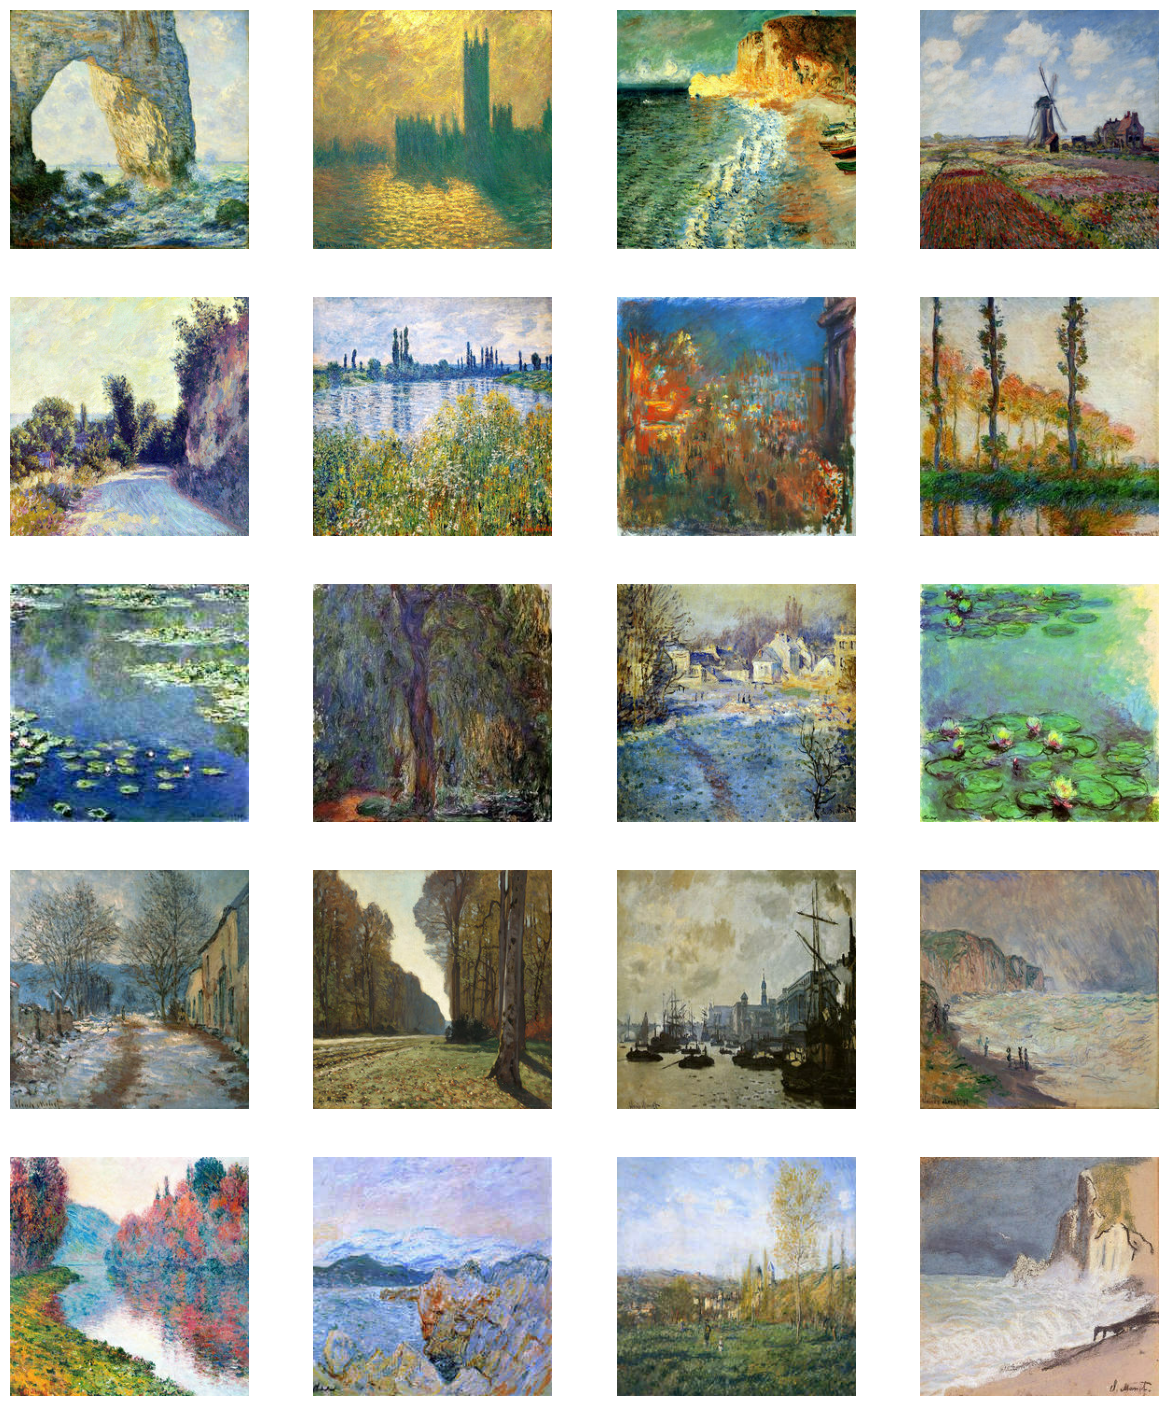

In [14]:
display_samples(load_dataset(monets_tfr).batch(1), 5, 4)

MODEL

To build the model, we will follow the following steps:

* Build the Generator
* Build the Discriminador
* Loss functions -
         Discriminator loss,
         Generator loss,
         Adversary loss,
         Cycle loss
* Identity loss
Define the optimizers

Downsampling the images for Generator

In [15]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.04)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

     
    result = keras.Sequential()
    # Convolutional layer
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
 # Normalization layer
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
 # Activation layer
    result.add(layers.LeakyReLU())

    return result

Upsampling the images for Generator


In [16]:
def upsample(filters, size, apply_dropout=False):
     # Normalization layer
    initializer = tf.random_normal_initializer(0., 0.04)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

     # Transpose convolutional layer
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
#Instance Normalization
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
# Dropout layer
    if apply_dropout:
        result.add(layers.Dropout(0.5))
# Activation layer
    result.add(layers.ReLU())

    return result

Generator -

The architecture of the generator is a modified U-Net, consisting of an encoder block and a decoder block, each of them is made up of simpler blocks of layers: Each block of the encoder, we call it downsample-k where k denotes the number of filters, consisting of the following layers:

* Convolution
* Instance Normalization 
* Leaky ReLU

In [17]:
OUTPUT_CHANNELS = 3
def Generator_PM():
    data = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_sample = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_sample = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
    initialize = tf.random_normal_initializer(0., 0.02)
    final = layers.Conv2DTranspose(3, 7,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initialize,
                                  activation='tanh') # (bs, 256, 256, 3)

    inputs = data

    # Downsampling through the model
    skip_connection = []
    for down in down_sample:
        inputs = down(inputs)
        skip_connection.append(inputs)
        
    skip_connection = reversed(skip_connection[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_sample, skip_connection):
        inputs = up(inputs)
        inputs = layers.Concatenate()([inputs, skip])

    inputs = final(inputs)

    return keras.Model(inputs=data, outputs=inputs)

In [18]:
generator = Generator_PM()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Discriminator - 

The task of the discriminator is whether an input image, which is (the output of a generator), is original or fake!
It can be seen that the architecture of the discriminator is a convolution network of the PatchGAN type, instead of returning whether the image is real or not, this architecture returns whether pieces of the image can be considered real or false. As we mentioned in the generator, the encoder is made up of downsample-k blocks, the block performs an image compression operation (downsample). It consists of the following layers:

* Convolution
* Instance Normalization 
* Leaky ReLU


In [19]:
def Discriminator_PM():
    initialize = tf.random_normal_initializer(0., 0.02)
    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    data = layers.Input(shape=[256, 256, 3], name='input_image')

    inputs = data

    down1 = downsample(64, 4, False)(inputs) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 7, strides=2,
                         kernel_initializer=initialize,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    final = layers.Conv2D(1, 7, strides=2,
                         kernel_initializer=initialize)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inputs, outputs=final)

In [20]:
discriminator_y = Discriminator_PM()
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
with tpu_strategy.scope():
    monet_generator = Generator_PM() # transforms photos to Monet-esque paintings
    photo_generator = Generator_PM() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator_PM() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator_PM() 

Implementing CycleGAN

In [22]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=20,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
             # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)
        
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [23]:
with tpu_strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with tpu_strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with tpu_strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

In [24]:
with tpu_strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

In [25]:
with tpu_strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, 
        monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

Fit the model

In [26]:
from keras.callbacks import ModelCheckpoint
modelCheckpoint = ModelCheckpoint(filepath = 'model.h5',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=False,
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)

In [30]:
with tf.device('/device:GPU:0'):
    cycle_gan_model.fit(
        data,
        epochs=30,
        steps_per_epoch=(max(monet_jpg, photo_jpg)//BATCH_SIZE),
        callbacks=[modelCheckpoint]
    )

Epoch 1/30


2023-12-10 11:08:18.997721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1759/1759 [==============================] - 1196s 668ms/step - monet_gen_loss: 5.3143 - photo_gen_loss: 5.3242 - monet_disc_loss: 0.5801 - photo_disc_loss: 0.5821
Epoch 2/30
1759/1759 [==============================] - 1003s 570ms/step - monet_gen_loss: 4.1137 - photo_gen_loss: 4.2389 - monet_disc_loss: 0.5830 - photo_disc_loss: 0.5568
Epoch 3/30
1759/1759 [==============================] - 980s 557ms/step - monet_gen_loss: 3.8369 - photo_gen_loss: 4.0597 - monet_disc_loss: 0.5895 - photo_disc_loss: 0.5364
Epoch 4/30
1759/1759 [==============================] - 981s 558ms/step - monet_gen_loss: 3.6838 - photo_gen_loss: 3.9695 - monet_disc_loss: 0.6007 - photo_disc_loss: 0.5340
Epoch 5/30
1759/1759 [==============================] - 994s 565ms/step - monet_gen_loss: 3.6041 - photo_gen_loss: 3.8878 - monet_disc_loss: 0.6053 - photo_disc_loss: 0.5413
Epoch 6/30
1759/1759 [==============================] - 982s 558ms/step - monet_gen_loss: 3.6295 - photo_gen_loss: 3.8968 - monet_disc_loss

: 

In [ ]:
import PIL
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

Creates the final zip folder for Kaggle Submission

In [ ]:
import os
os.makedirs('../images/') # Create folder to save generated images

predict_and_save(load_dataset(photos_tfr).batch(1), monet_generator, '../images/')

In [ ]:
import shutil
shutil.make_archive("../images", 'zip', "./images")

In [ ]:
print(f"Number of generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Display Generated Samples for Test Data

In [ ]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
    
        plt.subplot(121)
        plt.title("Input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [ ]:
display_generated_samples(load_dataset(photos_tfr).batch(1), monet_generator, 7)